## Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Pandas options setup

pd.set_option('display.max_columns', 100)
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Contents:
- SSP inverse emissions (CO2 CH4 N2O)
- SSP concentrations (CO2 CH4 N2O)
- SSP forcings
- SSP temperature plumes
- Comparison of C4MIP / FaIR carbon cycle feedback parameters?

### Supplementary figures
- comparison of the FaIR and GIR carbon cycle
- Etminan comparison (OLBL vs Etminan formulae)
- comparing the CH4 lifetime computation with Holmes
- 1pctCO2 / abrupt4xCO2, compare to CMIP6
- compare SSPs to CMIP6?

# NROY Ensemble Generation

## Part I: the Global Warming Index

In [2]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

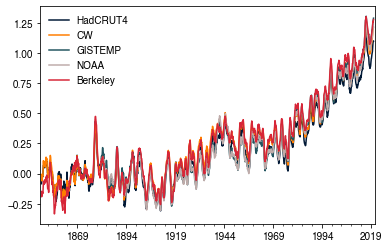

In [3]:
GMST_datasets.rolling(12).mean().plot()

In [4]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [5]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
# rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

In [6]:
## creating a forcing response dataset

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
erf_ar6 -= erf_ar6.loc[1750]

aer_ar6 = pd.read_csv('../tmp/aerosol_forcing.csv',index_col=0)

In [7]:
## generating many rf shapes for the GWI

N = 10000

rf_factors = {}

rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).co2*random_percentiles + ~(erf_ar6.mean()>0).co2*(1-random_percentiles))
rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)#ppf((erf_ar6.mean()>0).ch4*random_percentiles + ~(erf_ar6.mean()>0).ch4*(1-random_percentiles))
rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).n2o*random_percentiles + ~(erf_ar6.mean()>0).n2o*(1-random_percentiles))
rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).other_wmghg*random_percentiles + ~(erf_ar6.mean()>0).other_wmghg*(1-random_percentiles))
rf_factors['o3_tropospheric'] = sp.stats.norm(1,0.5/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_tropospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_tropospheric*(1-random_percentiles))
rf_factors['o3_stratospheric'] = sp.stats.norm(1,2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_stratospheric*(1-random_percentiles))
rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)#ppf((erf_ar6.mean()>0).h2o_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).h2o_stratospheric*(1-random_percentiles))
rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).contrails*random_percentiles + ~(erf_ar6.mean()>0).contrails*(1-random_percentiles))
rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).land_use*random_percentiles + ~(erf_ar6.mean()>0).land_use*(1-random_percentiles))
rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

pct_5 = 0.04 / 0.08
pct_95 = 0.18 / 0.08
sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

ant_rf_ensemble = np.zeros((270,N))
nat_rf_ensemble = np.zeros((270,N))

for agent in ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','land_use','bc_on_snow']:
    ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
for agent in ['volcanic','solar']:
    nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
## aerosol distribution 

### generate the mean shape:

RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

RCMIP_so2_emms -= RCMIP_so2_emms[0,0]
RCMIP_oc_emms -= RCMIP_oc_emms[0,0]
RCMIP_bc_emms -= RCMIP_bc_emms[0,0]

ERFari_shape = -0.002444 * RCMIP_so2_emms + 0.032223 * RCMIP_bc_emms + -0.009421 * RCMIP_oc_emms
ERFaci_shape = -1.41 * np.log(1 + RCMIP_so2_emms / 177) + -0.0105 * ( RCMIP_oc_emms + RCMIP_bc_emms )

## construct the Smith distributions 
def fit_skewnorm(x,X,percentiles):
    distr = sp.stats.skewnorm(*x)
    return sum(abs(distr.ppf(percentiles) - X))

ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

ERFaci_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFaci_smith_sknorm_params).rvs(N)[:,None]
ERFari_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFari_smith_sknorm_params).rvs(N)[:,None]

ERFari_samples = ERFari_smith_sknorm_distr / ERFari_shape[0,-1] * ERFari_shape
ERFaci_samples = ERFaci_smith_sknorm_distr / ERFaci_shape[0,-1] * ERFaci_shape

#### Alternative aerosol generation with varying shapes (work-in-progress):

In [8]:
# ## New aerosol generation methodology, following Smith et al (2020) ; multivariate gaussian distribution, sample parameters, generate shapes from emission data.
# ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
#        [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
#        [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
#        [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
#        [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
#        [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
#        [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
#        [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
#        [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
#        [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ERFari_sfs = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)
# ERFari_samples = (ERFari_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LINEAR ERFaci params
# # ERFaci_params = pd.DataFrame(data=np.array([[-0.23977316,  0.05033984, -0.0026841 ],
# #        [-0.03596736, -0.0061301 , -0.00999338],
# #        [-0.02306089, -0.00397075, -0.00440759],
# #        [-0.04100239, -0.00815999, -0.00296047],
# #        [-0.11952911,  0.01185454, -0.00136009],
# #        [-0.0751146 ,  0.0115965 , -0.00595064],
# #        [-0.00958696,  0.00027465, -0.00252801],
# #        [-0.10616509,  0.01464634, -0.00292868],
# #        [ 0.02490414, -0.02261304, -0.00721553],
# #        [ 0.06822656, -0.01548075, -0.01065098]])
# # ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
# #        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
# #        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ### LOG so2 ERFaci params
# ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
#        [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
#        [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
#        [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
#        [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
#        [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
#        [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
#        [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
#        [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
#        [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

# ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

# # ERFaci_params.loc[:,'so2_logcoef'] = np.log(-1*ERFaci_params.loc[:,'so2_logcoef'])

# ### LINEAR ERFaci params
# # ERFaci_sfs = sp.stats.multivariate_normal(ERFaci_params.mean(),ERFaci_params.cov()).rvs(N)
# # ERFaci_samples = (ERFaci_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LOG so2 ERFaci params
# beta_samples = -1 * np.exp( sp.stats.norm(ERFaci_params['log_beta'].mean(),ERFaci_params['log_beta'].std()).rvs(N) )[...,None]
# beta_s_samples = np.exp( sp.stats.norm(ERFaci_params['log_beta_s'].mean(),ERFaci_params['log_beta_s'].std()).rvs(N) )[...,None]
# s_samples = -1 * beta_samples / beta_s_samples
# alpha_samples = sp.stats.norm(ERFaci_params['alpha'].mean(),ERFaci_params['alpha'].std()).rvs(N)[...,None]

# RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

# ERFaci_samples = beta_samples * np.log(1+RCMIP_so2_emms/s_samples) + alpha_samples * ( RCMIP_oc_emms+RCMIP_bc_emms )

In [9]:
# # we now constrain the ERFari and ERFaci distributions to match the contrained Smith (2020) distributions through a quantile map.

# def fit_skewnorm(x,X,percentiles):
#     distr = sp.stats.skewnorm(*x)
#     return sum(abs(distr.ppf(percentiles) - X))

# ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
# ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

# ERFaci_smith_sknorm_distr = sp.stats.skewnorm(*ERFaci_smith_sknorm_params)
# ERFari_smith_sknorm_distr = sp.stats.skewnorm(*ERFari_smith_sknorm_params)

# def np_quantileatscore(a,score):
    
#     ## assumes both are numpy arrays and returns the quantiles for the score array (ordered)
    
#     return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

# ## map ERFaci+ERFari to the Smith distribution:

# aci_percentiles = np_quantileatscore(ERFaci_samples[:,-1],ERFaci_samples[:,-1])
# smith_samples = -1 * ERFaci_smith_sknorm_distr.ppf(1-aci_percentiles)
# ERFaci_samples *= (smith_samples/ERFaci_samples[...,-1])[:,None]

# ari_percentiles = np_quantileatscore(ERFari_samples[:,-1],ERFari_samples[:,-1])
# smith_samples = -1 * ERFari_smith_sknorm_distr.ppf(1-ari_percentiles)
# ERFari_samples *= (smith_samples/ERFari_samples[...,-1])[:,None]

In [10]:
tot_aer = (ERFari_samples+ERFaci_samples).T

ant_rf_ensemble += tot_aer

In [11]:
rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

<AxesSubplot:>

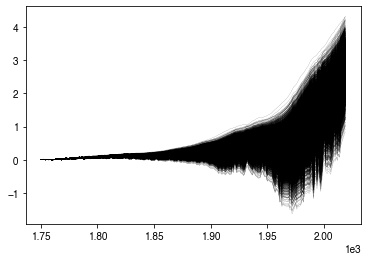

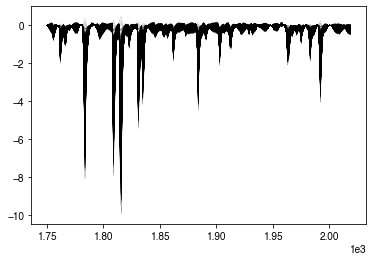

In [12]:
rf_ant.plot(legend=None,lw=0.1,c='k')

rf_nat.plot(legend=None,lw=0.1,c='k')

In [13]:
## create the response parameter ranges:

### based on inferred ranges from CMIP6
response_names = ['response_'+str(x) for x in np.arange(24)]
response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
response_params.loc[:] = 0

d1_range = [0.2,0.8,1.4,2]
d2_range = [4,8,12,16]
d3_range = [100,200,400,800]
q1_range = [0.04,0.16,0.28,0.4]

RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
ECS=3

i=0
for d_num in np.arange(4):
    for RWF in RWF_range:
        response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
        response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
        response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
        response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

        q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([ECS,ECS*RWF]),x0=np.array([0.32,0.47]),method='lm').x

        response_params.loc['q',(response_names[i],2)] = q2
        response_params.loc['q',(response_names[i],3)] = q3

        i+=1
            
## remove any that are unphysical (negative parameters)

response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)

In [14]:
## generate the temperature responses:

### reshape the rf dataframes into model inputs (only for old forcing data):
# rf_ant['YEAR'] = [x.year for x in rf_ant.index]
# rf_ant.set_index('YEAR',inplace=True)
# rf_ant.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_ant.columns],['forcing']])
# rf_ant = rf_ant.reindex(rf_ant.index.append(pd.Index([2018,2019])))
# rf_ant.loc[2018] = rf_ant.loc[2017]+(rf_ant.loc[2017] - rf_ant.loc[2012])/5
# rf_ant.loc[2019] = rf_ant.loc[2017]+2*(rf_ant.loc[2017] - rf_ant.loc[2012])/5

# rf_nat['YEAR'] = [x.year for x in rf_nat.index]
# rf_nat.set_index('YEAR',inplace=True)
# rf_nat.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_nat.columns],['forcing']])
# rf_nat.loc[2018] = rf_nat.loc[2017]+(rf_nat.loc[2017] - rf_nat.loc[2012])/5
# rf_nat.loc[2019] = rf_nat.loc[2017]+2*(rf_nat.loc[2017] - rf_nat.loc[2012])/5

##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant),forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat),forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:17<00:00, 15.81 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:17<00:00, 15.12 timestep/s]


/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

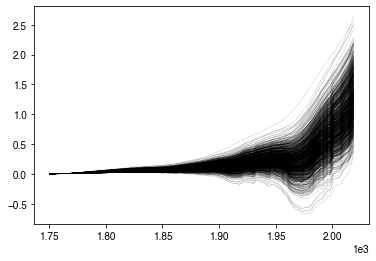

In [15]:
temp_ant.iloc[:,np.random.choice(18*N,1000)].plot(legend=False,lw=0.1,c='k')

In [16]:
## generate the temperature dataset:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:'2019'].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:2019].values - HadCRUT_ensmem.loc[:2019].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

In [17]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
#     e = Y - np.dot(X_1,B)
    
#     SSE = np.sum(e**2,axis=0)

#     MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

#     SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    return {'coefs':B[1:],'intercept':B[0]}
#     return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

In [18]:
ant_coefs = np.empty((100,temp_ant.shape[1]))
nat_coefs = np.empty((100,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)['coefs']
    ant_coefs[:,i] = _lreg_coefs[0]
    nat_coefs[:,i] = _lreg_coefs[1]
#     ant_coefs.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:43<00:00, 635.53it/s]


In [19]:
## computing the uncertainty from internal variability

### get internal variability timeseries:

CMIP6_int_var = pd.read_csv('../tools/cmip6_data/piControl_tas.csv',index_col=0)

### subsample 100 * 170 year slices
### check if drift, discard if drift
### randomly pick one non-drifting sample

CMIP6_int_var_samples = pd.DataFrame(index=np.arange(170))
for model,data in CMIP6_int_var.iteritems():
    arr = data.dropna().values
    chunksize = arr.size
    if chunksize<170:
        continue
    starting_points = np.random.choice(np.arange(chunksize-170),100)
    nodrift_points = []
    for s in starting_points:
        subarr = arr[s:s+170]
        drift = sp.stats.linregress(np.arange(170),subarr).slope
        if drift*100>0.15:
            continue
        else:
            nodrift_points+=[s]
    chosen_start = np.random.choice(nodrift_points)
    CMIP6_int_var_samples.loc[:,model] = arr[chosen_start:chosen_start+170] - arr[chosen_start:chosen_start+170].mean()

In [20]:
### remove model degeneracies:

int_var_models = []
for model in CMIP6_int_var_samples.columns:
    if [x.split('_')[1] for x in CMIP6_int_var_samples.columns].count(model.split('_')[1]) > 1:
        all_mems = [x for x in CMIP6_int_var_samples.columns if x.split('_')[1] == model.split('_')[1]]
        all_mems = [x.split('_')[2] for x in all_mems]
        curr_mem = model.split('_')[2]
        all_mem_nos = np.array([int(''.join(re.findall(r'\d+',mem))) for mem in all_mems])
        curr_mem_no = int(''.join(re.findall(r'\d+',curr_mem)))
        if all(curr_mem_no < all_mem_nos):
            int_var_models += [model]
            continue
    else:
        int_var_models += [model]
        
CMIP6_int_var_samples_nondeg = CMIP6_int_var_samples.loc[:,int_var_models]

<AxesSubplot:>

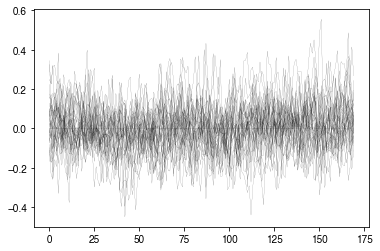

In [21]:
CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

In [22]:
ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_ant.shape[1]))
nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs_iv.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,CMIP6_int_var_samples_nondeg.values)['coefs']
    ant_coefs_iv[:,i] = _lreg_coefs[0]
    nat_coefs_iv[:,i] = _lreg_coefs[1]
#     ant_coefs_iv.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs_iv.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:42<00:00, 636.75it/s]


In [23]:
chosen_year = 2014

## computing the present day value:
temp_attr_ant = pd.DataFrame(ant_coefs * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_attr_nat = pd.DataFrame(nat_coefs * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate:
temp_rate_attr_ant = pd.DataFrame(ant_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_rate_attr_nat = pd.DataFrame(nat_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day value uncertainty from internal variability:
temp_attr_ant_iv = pd.DataFrame(ant_coefs_iv * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()
temp_attr_nat_iv = pd.DataFrame(nat_coefs_iv * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate uncertainty from internal variability:
temp_rate_attr_ant_iv = pd.DataFrame(ant_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()
temp_rate_attr_nat_iv = pd.DataFrame(nat_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()

In [24]:
## combine the sources of uncertainty:

temp_attr_ant_and_iv = (temp_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_attr_nat_and_iv = (temp_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

temp_rate_attr_ant_and_iv = (temp_rate_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_rate_attr_nat_and_iv = (temp_rate_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

In [27]:
# print('Anthro Temp statistics')
# print(temp_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nAnthro Temp rate statistics')
# print(temp_rate_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp statistics')
# print((temp_attr_ant+temp_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp rate statistics')
# print((temp_rate_attr_ant+temp_rate_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

HIGH_constrain_level,LOW_constrain_level = np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.95,0.05])
HIGH_constrain_rate,LOW_constrain_rate = np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.95,0.05])

print('Temp level constraint:')
print(np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.05,0.5,0.95]))

print('\nTemp rate constraint:')
print(np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.05,0.5,0.95]))

Temp level constraint:
[0.67395639 1.06875932 1.2597369 ]

Temp rate constraint:
[0.02091439 0.03002626 0.0422343 ]


Text(0, 0.5, 'rate of temperature change over 2015-2019 / K decade$^{-1}$')

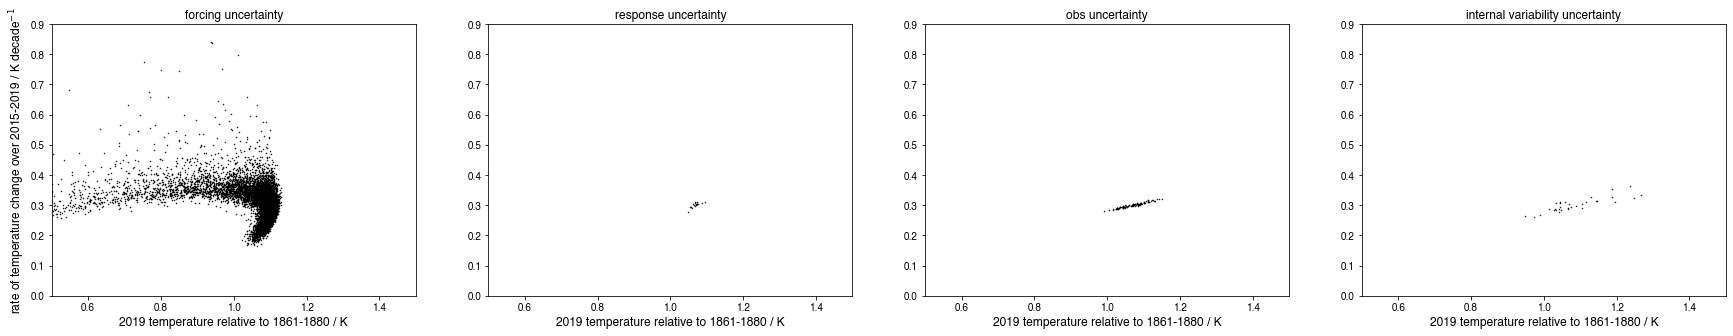

In [29]:
fig,ax=plt.subplots(1,4,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['forcing','response','obs','internal variability']):
    ax[i].scatter(np.median(temp_attr_ant_and_iv+temp_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),10*np.median(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),color='k',marker='.',s=1)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2019 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2015-2019 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)

## Part II: constraining a large parameter ensemble

In [2]:
## start from here if you don't want to re-run the GWI:
baseline = [1861,1880]
chosen_year = 2014
HIGH_constrain_level,LOW_constrain_level = [1.2597369 , 0.67395639]
HIGH_constrain_rate,LOW_constrain_rate = [0.0422343 , 0.02091439]

#### Forcing parameter uncertainties
We construct ensembles of the ERF parameters used in the model by scaling each default ERF parameter by a scaling factor sampled from the appropriate distribution:
- CO$_2$ ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.28}{\Phi^{-1}(0.95)}\right)$
- N$_2$O ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- other WMGHGs ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- tropospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- stratospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{2}{\Phi^{-1}(0.95)}\right)$
- stratospheric H$_2$O from CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.72}{\Phi^{-1}(0.95)}\right)$
- BC on snow ~ lognormal with quantiles 0.05 = 0.5 and 0.95 = 2.25
- contrails ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- ERFari ~ $\alpha$ parameters drawn from CMIP6 inferred multivariate normal; resulting distribution scaled to match process based assessment in Bellouin (2020)
- ERFaci ~ parameters drawn independently from CMIP6 inferred distribution; resulting distribtuion scaled to match process based assessment Bellouin (2020)
- LUC ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- volcanic ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- solar ~ $\mathcal{N}\left(1,\frac{1}{\Phi^{-1}(0.95)}\right)$

N.B. the numerator in each normal distribution scale parameter gives the half the 90% confidence interval (ie. uncertainty in CO$_2$ ERF is $\pm20\%$).

In [3]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

def get_forcing_param_ensemble(N,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    category_distributions = pd.Series(index = param_categories.keys(),dtype=object)

    category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)
    category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)
    category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)
    category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)
    category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)
    pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
    pct_95=0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))
    category_distributions.loc['contrails'] = sp.stats.norm(1,0.75/1.645)

    f_parameter_ensemble_draw = np.zeros((3,len(forcing_namelist),N))
    default_f_params = default_params.loc['f1':'f3'].values

    for key in category_distributions.index:
        if not type(category_distributions.loc[key]) == sp.stats._distn_infrastructure.rv_frozen:
            continue
        cat_map = [x in param_categories[key] for x in forcing_namelist]
        f_parameter_ensemble_draw[:,cat_map,:] = default_f_params[:,cat_map,None] * category_distributions.loc[key].rvs(N)[None,None]
        
    ## draw aerosol parameters based on inferred CMIP6 ranges (see CMIP6_parameter_ranges notebook), then rescaled to match the Bellouin process based assessment

    ## compute parameters, then scale by the Bellouin / 1850-(2005:2015)
    
    ERFari_mean = np.array([ 0.0322228,  -0.00942092, -0.00244355])
    ERFari_cov = np.array([[ 3.15369655e-03, -8.82303049e-04, -7.48817290e-05], [-8.82303049e-04,  2.73438810e-04,  1.93224159e-05], [-7.48817290e-05,  1.93224159e-05,  2.79943211e-06]])

    ERFari_param_draw = sp.stats.multivariate_normal(ERFari_mean,ERFari_cov).rvs(N)
    
    ERFaci_ln_beta_s_cov = np.array([[ 1.91733923, -0.50602743], [-0.50602743,  0.39434683]])
    ERFaci_ln_beta_s_mean = np.array([ 0.34360154, -4.83319076])
    ERFaci_alpha_mean = -0.01052545531769231
    ERFaci_alpha_std = 0.00708497464821015

    ERFaci_beta_s = np.exp(sp.stats.multivariate_normal(ERFaci_ln_beta_s_mean,ERFaci_ln_beta_s_cov).rvs(N))
    ERFaci_alpha = sp.stats.norm(ERFaci_alpha_mean,ERFaci_alpha_std).rvs(N)
    ERFaci_beta = -1*ERFaci_beta_s[...,0]
    ERFaci_s = ERFaci_beta_s[...,0] / ERFaci_beta_s[...,1]
    
    ## get aerosol emissions
    RCMIP_aer_emms = RCMIP_emms.loc[('World','ssp245',['Emissions|Sulfur','Emissions|OC','Emissions|BC'])].iloc[:,4:].droplevel((0,1)).apply(pd.to_numeric).T.interpolate().loc[:'2019']
    ## baseline to be zero in 1750
    RCMIP_aer_emms -= RCMIP_aer_emms.loc['1750']

    ## generate the 1850 - 2010 change
    ERFari_1850_2010 = ((RCMIP_aer_emms.loc['2005':'2010'].mean() - RCMIP_aer_emms.loc['1850']).values * ERFari_param_draw).sum(axis=1)

    ERFaci_1850_2010 = ERFaci_beta * ( np.log(1 + RCMIP_aer_emms.loc['2005':'2010','Emissions|Sulfur'].mean()/ERFaci_s) - np.log(1 + RCMIP_aer_emms.loc['1850','Emissions|Sulfur'].mean()/ERFaci_s) ) \
    + ERFaci_alpha * (RCMIP_aer_emms.loc['2005':'2010',['Emissions|OC','Emissions|BC']].mean().sum() - RCMIP_aer_emms.loc['1850',['Emissions|OC','Emissions|BC']].sum())
    
    # Use Nicolas' Ringberg methods
    def uniform1684(a,b,seed,samples=2000):
        interval = (b-a)+((b-a)/(84-16)*32)
        lower = a-((b-a)/(84-16)*16)
        return sp.stats.uniform.rvs(lower, interval, size=samples, random_state=seed)
    samples=N
    dtau    = uniform1684(0.02,0.04,123,samples=samples)
    tau     = uniform1684(0.13,0.17,124,samples=samples)
    S_tau   = uniform1684(-27,-20,125,samples=samples)
    RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
    dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
    dRatm_dtau = uniform1684(17,35,128,samples=samples)
    c_tau    = uniform1684(0.59,0.71,129,samples=samples)
    c_N      = uniform1684(0.19,0.29,130,samples=samples)
    c_L      = uniform1684(0.21,0.29,131,samples=samples)
    c_C      = uniform1684(0.59,1.07,132,samples=samples)
    beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
    beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
    beta_C_N   = uniform1684(0,0.1,135,samples=samples)
    S_N = uniform1684(-27,-26,136,samples=samples)
    S_L = uniform1684(-56,-54,137,samples=samples)
    S_C = uniform1684(-153,-91,138,samples=samples)

    rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
    rfari_adj = dtau*dR_dRatm*dRatm_dtau

    dlntau = dtau/tau
    deltan = dlntau * beta_N_tau

    rfaci = dlntau*beta_N_tau*S_N*c_N
    erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
    erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

    ERFari_scale = rfari + rfari_adj
    ERFaci_scale = rfaci + erfaci_L + erfaci_C
    
    def np_quantileatscore(a,score):
    
        return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

    ERFari_qmap = (ERFari_scale[np.argsort(ERFari_scale)][(np_quantileatscore(ERFari_1850_2010,ERFari_1850_2010)*N).astype(int)] / ERFari_1850_2010)
    ERFaci_qmap = (ERFaci_scale[np.argsort(ERFaci_scale)][(np_quantileatscore(ERFaci_1850_2010,ERFaci_1850_2010)*N).astype(int)] / ERFaci_1850_2010)
    
    for i,cat in enumerate(['bc','oc','so2']):
        cat_map = forcing_namelist.index(cat)
        f_parameter_ensemble_draw[1,cat_map,:] = ERFari_param_draw[...,i]*ERFari_qmap

    so2_PI_conc_ensemble = ERFaci_s.copy()

    cat_map = forcing_namelist.index('so2|aci')
    f_parameter_ensemble_draw[0,cat_map,:] = ERFaci_beta*ERFaci_qmap

    cat_map = forcing_namelist.index('oc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    cat_map = forcing_namelist.index('bc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    
    gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=mem_names)

    gas_parameter_ensemble.loc['f1':'f3',:] = f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:]

    gas_parameter_ensemble.loc['PI_conc',(slice(None),'so2')] = so2_PI_conc_ensemble[:]
    
    return gas_parameter_ensemble

#### Response parameter uncertainties

In [4]:
def get_response_params(N,gas_parameter_ensemble,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    ## require gas_params for the F_2x value

    ## draw ln d1, ln d2, q1 | ln d3 | RWF | TCR

    # covariance of ln_d1, d2, q1
    cov_mat_1 = np.array([[0.95199915, 0.47649902, 0.09359745], [0.47649902, 0.59388914, 0.09119872], [0.09359745, 0.09119872, 0.01710808]])

    mean_mat_1 = np.array([-0.20227299,  2.05243353,  0.20285564])
    
    ln_d3_mean = 5.76338587
    ln_d3_std = 0.57722689
    
    # we alter the CMIP6 assessed ranges to cover a slighly wider range
    RWF_mean = 0.55 # 0.55124171
    RWF_std = 0.3/1.645 # 0.13777385
    
    TCR_mean = 2# 2.0782074
    TCR_std = 1/1.645# 0.45012178

    F_2x = gas_parameter_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_parameter_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , lnd2 , q1 , RWF , lnd3 , TCR , d1, d2, d3 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((15,N))

    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()

    while N_neg>0:

        lnd1[neg_idx], lnd2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
        lnd3[neg_idx] = sp.stats.norm(ln_d3_mean, ln_d3_std).rvs(N_neg)
        RWF[neg_idx] = sp.stats.truncnorm(-3,3,RWF_mean, 0.15).rvs(N_neg)
        TCR[neg_idx] = sp.stats.truncnorm(-3,3,TCR_mean, TCR_std).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.uniform(0.25,0.6).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.uniform(1,2).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.norm(0.55,0.15).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.norm(2.05,0.5).rvs(N_neg)
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        d2[neg_idx] = np.exp(lnd2[neg_idx])
        d3[neg_idx] = np.exp(lnd3[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()

    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=mem_names)
    thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)
    
    return thermal_parameter_ensemble

We run in chunks of 10,000 at a time to reduce the RAM consumption

In [5]:
def run_CONSTRAIN(N,ssp='ssp245',mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    # forcing uncertainty
    ## anothropogenic
    gas_parameter_ensemble = get_forcing_param_ensemble(10000,mem_names=mem_names)
    
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    ## LUC
    LUC_forc = erf_ar6[['land_use']].reindex(np.arange(1750,2101)).values
    LUC_forc_ensemble = sp.stats.norm(1,0.75/1.645).rvs(N)[None] * LUC_forc
    
    ## Natural
    volc_forc = erf_ar6[['volcanic']].reindex(np.arange(1750,2101)).values
    volc_forc_ensemble = sp.stats.norm(1,0.5/1.645).rvs(N)[None] * volc_forc
    sol_forc = erf_ar6[['solar']].reindex(np.arange(1750,2101)).values
    sol_forc_ensemble = sp.stats.norm(1,1/1.645).rvs(N)[None] * sol_forc
    
    ssp_forc = pd.DataFrame(LUC_forc_ensemble+sol_forc_ensemble+volc_forc_ensemble,index=np.arange(1750,2101),columns=pd.MultiIndex.from_product([mem_names,['forcing']]) )
    
    # carbon cycle uncertainty
    cc_uncertainty = 0.13 / 1.645 * (4.165 / 3.587)
    cc_param_draw = sp.stats.norm(1,0.13/1.645).rvs(N).reshape(1,-1)
    gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw
    
    # response uncertainty
    thermal_parameter_ensemble = get_response_params(10000,gas_parameter_ensemble,mem_names)
    
    # get ssp emissions
    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2101))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)
    ssp_emms = pd.concat([ssp_emms]*N,axis=1,keys=mem_names)
    # switch in GCP for CO2
    
    # run the model
    FULL = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)
    
    # get the constraints:
    temp_constraint = ((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())<HIGH_constrain_level)&((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())>LOW_constrain_level)
    rate_constraint = (FULL['T'].diff(5).loc[chosen_year]/5<HIGH_constrain_rate)&(FULL['T'].diff(5).loc[chosen_year]/5>LOW_constrain_rate)
    
    _output = pd.DataFrame(index=['ECS','TCR'],columns=FULL['T'].columns.levels[-1])

    f = gas_parameter_ensemble.loc['f1':'f3',(slice(None),'carbon_dioxide')].values
    F_2x = f[0]*np.log(2)+f[2]*(np.sqrt(278*2)-np.sqrt(278))
    _output.loc['ECS',:] = F_2x*thermal_parameter_ensemble.loc['q'].values.reshape(-1,3).sum(axis=1)
    _output.loc['TCR',:] = F_2x * ( thermal_parameter_ensemble.loc['q'].values.reshape(-1,3) * (1 - (thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)/69.66) * ( 1 - np.exp(-69.66/thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)) ) ) ).sum(axis=1)
        
    _output.loc['T_2100',:] = (FULL['T'].loc[2100] - FULL['T'].loc[baseline[0]:baseline[1]].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    for forc_cat in param_categories.keys():
    
        _output.loc[forc_cat+'_2019',:] = FULL['RF'].loc[2019,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()
        
    _output.loc['GHG_2019',:] = _output.loc[[x+'_2019' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
    _output.loc['aer_2019',:] = _output.loc[[x+'_2019' for x in ['aci','ari']]].sum()
    _output.loc['anthro_2019',:] = _output.loc[[x+'_2019' for x in param_categories.keys()]].sum()
    
    _output.loc['constrain_level',:] = temp_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_rate',:] = rate_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_multi',:] = (temp_constraint&rate_constraint).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    gas_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/gas_params_'+mem_names[0]+'-'+mem_names[-1]+'_v1.pkl')
    thermal_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/response_params_'+mem_names[0]+'-'+mem_names[-1]+'_v1.pkl')
    temp_constraint.to_pickle('../Parameter_Sets/NROY/temp_constraint_'+mem_names[0]+'-'+mem_names[-1]+'_v1.pkl')
    rate_constraint.to_pickle('../Parameter_Sets/NROY/rate_constraint_'+mem_names[0]+'-'+mem_names[-1]+'_v1.pkl')
    
    return _output

In [6]:
## run a total of 1000,000 ensembles:
results = []
for i in np.arange(200):
    results+=[run_CONSTRAIN(10000,mem_names=['mem'+str(x) for x in np.arange(10000*(i),10000*(i+1))])]

Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.66 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.50 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.24 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.39 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.37 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.30 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.85 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.08 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.26 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.08 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:30<00:00, 11.66 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 12.03 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.75 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:30<00:00, 11.50 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.90 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.90 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 12.01 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.23 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.71 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.82 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.69 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.81 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.54 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.96 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.85 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.90 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.64 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.93 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.14 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.84 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.86 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.74 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.09 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.70 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.82 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.25 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.43 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.64 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 12.99 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.61 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.67 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.08 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.86 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.72 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.00 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.72 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.00 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.88 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.82 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.06 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.94 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.14 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.09 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.25 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.07 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 12.97 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.90 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.90 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.88 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.69 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.88 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.55 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.62 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.63 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.61 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.37 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.65 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.32 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.69 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.82 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.25 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.74 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.82 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.34 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.22 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.16 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.38 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.33 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.11 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.18 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.30 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.83 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.88 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.70 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.46 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.54 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.13 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.01 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.12 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.56 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.63 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.21 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.92 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.01 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.41 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.66 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.43 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.25 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 12.98 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.56 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.84 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.07 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.87 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.92 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.68 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.85 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.21 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.11 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 12.98 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.38 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.76 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.72 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:30<00:00, 11.45 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 12.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:29<00:00, 11.86 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.26 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.28 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.10 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.94 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.79 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.79 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.57 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.80 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:28<00:00, 12.26 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.62 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.95 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.79 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.22 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.10 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.14 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.06 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.94 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.53 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.55 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.92 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.01 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.09 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 12.99 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.28 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.28 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.23 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.87 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.06 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.05 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.17 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.02 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.13 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.68 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.31 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.94 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.97 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.04 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.52 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.70 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.65 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.88 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.96 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.26 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.95 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.27 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.34 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.33 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.30 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.40 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.37 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.33 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.38 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.37 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.36 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.34 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:22<00:00, 15.32 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.37 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.22 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.63 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:23<00:00, 14.61 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:24<00:00, 14.39 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.41 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.87 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:27<00:00, 12.71 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:25<00:00, 13.61 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'h

100%|██████████| 350/350 [00:26<00:00, 13.36 timestep/s]


In [7]:
FULL_results = pd.concat(results,axis=1).apply(pd.to_numeric).dropna(axis=1)

## Analysis of output

In [8]:
## obtain some cmip6 parameter ranges for tas / ECS / TCR / aer_2019

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
## response params
CMIP6_response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

CMIP6_response_params.loc['ECS'] = np.nan
CMIP6_response_params.loc['TCR'] = np.nan
for model in CMIP6_response_params.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(CMIP6_response_params.loc[:'F_4x',model].values)],axis=1,keys=[model])
    CMIP6_response_params.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = CMIP6_response_params.loc['F_2x',model]).iloc[:,0]
CMIP6_response_params.loc['RWF'] = CMIP6_response_params.loc['TCR'] / CMIP6_response_params.loc['ECS']


# ERFari/aci: APRP data very noisy so we use the emissions based fits:
ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

ssp_emms = RCMIP_to_GIR_input_emms('ssp245').interpolate().reindex(np.arange(1750,2101))
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values

CMIP6_aer_forc_2019 = pd.DataFrame(index=ERFari_params.index,columns=['aci','ari','aer'])

for model in CMIP6_aer_forc_2019.index:
    CMIP6_aer_forc_2019.loc[model,'ari'] = ssp_emms.loc[2019,'so2']*ERFari_params.loc[model,'so2'] + ssp_emms.loc[2019,'bc']*ERFari_params.loc[model,'bc'] + ssp_emms.loc[2019,'oc']*ERFari_params.loc[model,'oc']
    CMIP6_aer_forc_2019.loc[model,'aci'] = ERFaci_params.loc[model,'beta'] * np.log(1+ssp_emms.loc[2019,'so2']/ERFaci_params.loc[model,'s']) + ERFaci_params.loc[model,'alpha']*(ssp_emms.loc[2019,'bc']+ssp_emms.loc[2019,'oc'])
    CMIP6_aer_forc_2019.loc[model,'aer'] = CMIP6_aer_forc_2019.loc[model,'aci'] + CMIP6_aer_forc_2019.loc[model,'ari']

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [9]:
plot_cmip6_tas2100 = ssp_tas.loc[:].xs('ssp245',axis=1,level=-1).drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=0,axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

In [10]:
# ssp_tas.loc[:,ssp_tas.loc[1850]<280]
# CMIP6_response_params.loc[['ECS','TCR']].T

In [11]:
def custom_kde(x,y):
    
    ## first remove the FAR outliers (5-sigma) from x and y in turn
    
    x_rank = np.argsort(x)
    x = x[x_rank]
    y = y[x_rank]
    num_outlier_high = -1*(x>(x.mean()+5.2*x.std())).sum()
    num_outlier_low = (x<(x.mean()-5.2*x.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]


    y_rank = np.argsort(y)
    x = x[y_rank]
    y = y[y_rank]
    num_outlier_high = -1*(y>(y.mean()+5.2*y.std())).sum()
    num_outlier_low = (y<(y.mean()-5.2*y.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]
    
    gridsize=100
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    
    return xi,yi,zi,dens_contours

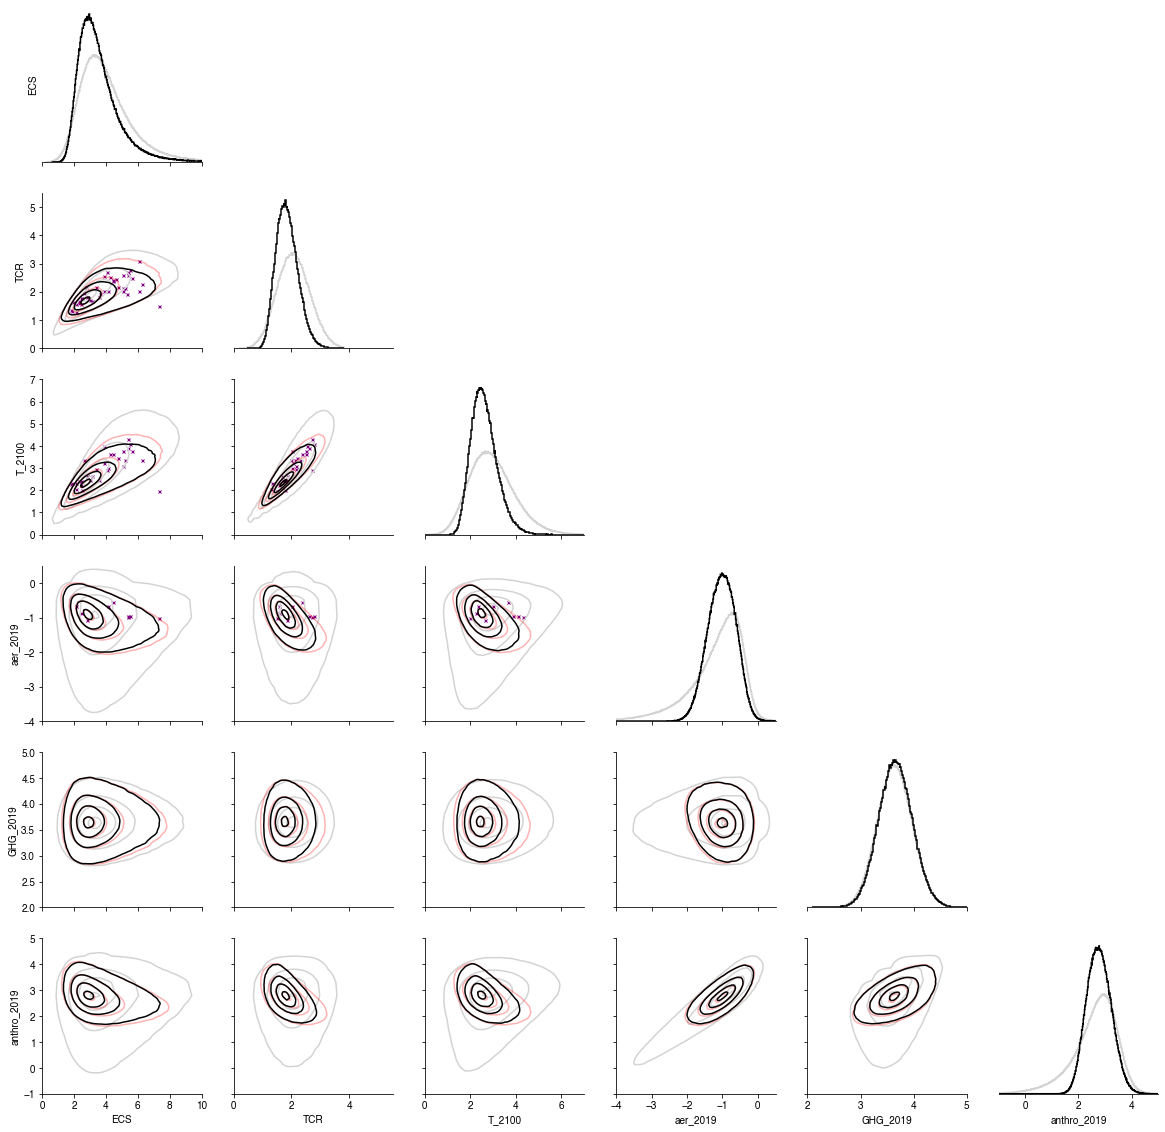

In [22]:
## create a correlation matrix plot:

cor_vars = ['ECS','TCR','T_2100','aer_2019','GHG_2019','anthro_2019']

fig,ax = plt.subplots(len(cor_vars),len(cor_vars),figsize=(20,20))

[ax[i,j].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j>i]

## plot the distributions:

for i in np.arange(len(cor_vars)):
    ax[i,i].hist(FULL_results.loc[cor_vars[i]].values.flatten(),histtype='step',color='lightgrey',density=True,lw=1.5)
    ax[i,i].hist(FULL_results.loc[cor_vars[i],FULL_results.loc['constrain_multi'].astype(bool)].values.flatten(),histtype='step',color='k',density=True,lw=1.5)
    
## do some kde plots
import multiprocessing
def kde_wrapper(i,j,constrain):
    if constrain:
        result = custom_kde(FULL_results.loc[cor_vars[j],FULL_results.loc[constrain].astype(bool)].values.flatten(),FULL_results.loc[cor_vars[i],FULL_results.loc[constrain].astype(bool)].values.flatten())
    else:
        result = custom_kde(FULL_results.loc[cor_vars[j]].values.flatten(),FULL_results.loc[cor_vars[i]].values.flatten())
        
    return result
        
# derive the kdes:
        
P1=multiprocessing.Pool(processes=4)
plot_indices = [[i,j,False] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_FULL = P1.starmap(kde_wrapper,plot_indices)
plot_indices = [[i,j,'constrain_level'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_level = P1.starmap(kde_wrapper,plot_indices)
plot_indices = [[i,j,'constrain_multi'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_constrain = P1.starmap(kde_wrapper,plot_indices)
P1.close()

# plot the kdes:
[ax[x[0],x[1]].contour(kde_FULL[i][0],kde_FULL[i][1],kde_FULL[i][2],kde_FULL[i][3],colors='lightgrey') for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_level[i][0],kde_level[i][1],kde_level[i][2],kde_level[i][3],colors='red',alpha=0.3) for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_constrain[i][0],kde_constrain[i][1],kde_constrain[i][2],kde_constrain[i][3],colors='k') for i,x in enumerate(plot_indices)]

# plot CMIP6 samples:
cmip6_samples = [CMIP6_response_params.loc['ECS'],CMIP6_response_params.loc['TCR'],plot_cmip6_tas2100.loc[2091:2100].mean(),CMIP6_aer_forc_2019.aer]
for i in np.arange(4):
    for j in np.arange(4):
        if j<i:
            intersection = list(set(cmip6_samples[i].index).intersection(set(cmip6_samples[j].index)))
            ax[i,j].plot(cmip6_samples[j].loc[intersection],cmip6_samples[i].loc[intersection],'x',color='purple',ms=3,zorder=0)

axes_lims = [[0,10],[0,5.5],[0,7],[-4,0.5],[2,5],[-1,5]]

[ax[i,j].set_xlim(axes_lims[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars))]
[ax[i,j].set_ylim(axes_lims[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[ax[i,j].set_ylabel(cor_vars[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j==0]
[ax[i,j].set_xlabel(cor_vars[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i==5]

## diagonal axes
[ax[i,i].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for pos in ['top','right','left']]
[ax[i,i].tick_params(left=False,labelleft=False) for i in np.arange(len(cor_vars))]

[ax[i,j].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) for pos in ['top','right']]
[ax[i,j].tick_params(labelleft=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j!=0]
[ax[i,j].tick_params(labelbottom=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i!=5]
print()

In [18]:
[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/NROY_corr_1e6mem.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

[None, None, None]

#### NROY targets (5-[16]-50-[84]-95%):

- ECS: 2 - 2.5 - 3 - 4 - 5
- TCR: 1.2 - 1.4 - 1.8 - 2.2 - 2.4
- GSAT: 1.1K 1850-1900 to 2009-2018
ERFs
- co2: 1.89 - 2.15 - 2.41
- methane: 0.43 - 0.54 - 0.65
- trop_o3: 0.18 - 0.35 - 0.52
- strat_o3: -0.15 -0.05 0.00
- ari (Smith): -0.60 -0.45 -0.27 -0.14 -0.07
- aci (Smith): -1.17 -0.93 -0.59 -0.29 -0.13
- anthro_erf: 1.56 - 2.53 - 3.32

In [14]:
## RCMIP emissions cumulative co2 is low compared to GCP (615 vs 678)
## should i remove the 1750 values??

In [13]:
FULL_results.loc[:,FULL_results.loc['constrain_multi'].astype(bool)].iloc[:-3].T.describe(percentiles=[.05,.16,.5,.84,.95]).T.iloc[:,[1,4,5,6,7,8]].round(2)

,mean,5%,16%,50%,84%,95%
ECS,3.57,1.99,2.41,3.29,4.67,6.10
TCR,1.85,1.29,1.48,1.82,2.22,2.51
T_2100,2.61,1.78,2.06,2.55,3.16,3.64
other_wmghgs_2019,0.36,0.29,0.32,0.36,0.40,0.43
carbon_dioxide_2019,2.09,1.66,1.83,2.09,2.35,2.53
methane_2019,0.61,0.44,0.51,0.61,0.71,0.78
nitrous_oxide_2019,0.20,0.16,0.18,0.20,0.23,0.24
trop_o3_2019,0.39,0.19,0.27,0.39,0.50,0.58
strat_o3_2019,-0.05,-0.14,-0.10,-0.05,0.01,0.04
strat_h2o_2019,0.06,0.02,0.03,0.06,0.09,0.10


In [16]:
FULL_results.iloc[:-3].T.describe(percentiles=[.05,.16,.5,.84,.95]).T.iloc[:,[1,4,5,6,7,8]].round(2)

,mean,5%,16%,50%,84%,95%
ECS,4.06,1.91,2.53,3.73,5.49,7.26
TCR,2.07,1.18,1.51,2.06,2.64,3.02
T_2100,2.97,1.50,2.00,2.88,3.94,4.75
other_wmghgs_2019,0.36,0.29,0.32,0.36,0.40,0.43
carbon_dioxide_2019,2.07,1.62,1.79,2.06,2.34,2.53
methane_2019,0.62,0.45,0.51,0.62,0.72,0.79
nitrous_oxide_2019,0.20,0.16,0.18,0.20,0.23,0.24
trop_o3_2019,0.39,0.20,0.27,0.39,0.51,0.59
strat_o3_2019,-0.05,-0.14,-0.10,-0.05,0.01,0.05
strat_h2o_2019,0.06,0.02,0.03,0.06,0.09,0.10
